In [1]:
import sys
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
sys.path.append("../pydens/")

RuntimeError: KeyboardInterrupt: 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from plotly import graph_objects as go

## Importing `solver` and tokens

In [4]:
from model_torch import Solver, D, V, CustomModel, TorchModel
from batchflow import NumpySampler as NS

In [5]:
# class LargerModel(TorchModel):
#     def __init__(self, **kwargs):
#         """ Simple model for solving PDEs - inherits base torch-model.
#         """
#         super().__init__(**kwargs)

#         # define network layers
#         self.fc1 = nn.Linear(self.ndims + self.nparams, 20)
#         self.ac1 = nn.Tanh()
#         self.fc2 = nn.Linear(20, 30)
#         self.ac2 = nn.Tanh()
#         self.fc3 = nn.Linear(30, 20)
#         self.ac3 = nn.Tanh()
#         self.fc4 = nn.Linear(20, 1)

#     def forward(self, *xs):
#         xs = super().forward(*xs)
#         u = self.fc1(xs)
#         u = self.ac1(u)
#         skip = u

#         u = self.fc2(u)
#         u = self.ac2(u)

#         u = self.fc3(u)
#         u += skip
#         u = self.ac3(u)

#         u = self.fc4(u)

#         return self.anzatc()(u, xs)

## Simple ODESampler

In [6]:
def ode(f, x):
    return D(f, x) - 2 * np.pi * torch.cos(2 * np.pi * x)

In [7]:
solver = Solver(ode, ndims=1, initial_condition=torch.tensor(.5))

In [8]:
solver.fit(niters=1500, batch_size=400)

100%|██████████| 1500/1500 [00:02<00:00, 516.24it/s]


In [9]:
xs = torch.tensor(np.linspace(0, 1, 100)).float()
approxs = solver.model(xs)

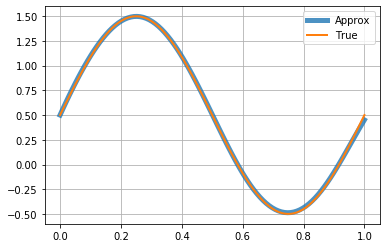

In [10]:
plt.plot(xs.detach().numpy(), approxs.detach().numpy(), label='Approx',
         linewidth=5, alpha=0.8)
plt.plot(xs.detach().numpy(), np.sin(2 * np.pi * xs.detach().numpy()) + .5,
         label='True', linewidth=2)
plt.grid()
plt.legend()

## Simple PDE

In [5]:
def pde(f, x, y):
    return D(D(f, x), x) + D(D(f, y), y) - 5 * torch.sin(np.pi * (x + y))

In [6]:
solver = Solver(pde, ndims=2, boundary_condition=1)

In [7]:
solver.fit(niters=500, batch_size=400, lr=0.05)

100%|██████████| 500/500 [00:03<00:00, 148.65it/s]


In [8]:
def cart_prod(*arrs):
    """ Get array of cartesian tuples from arbitrary number of arrays.
    """
    grids = np.meshgrid(*arrs, indexing='ij')
    return np.stack(grids, axis=-1).reshape(-1, len(arrs))

In [150]:
grid = cart_prod(np.linspace(0, 1, 100),
                 np.linspace(0, 1, 100))

In [151]:
approxs = solver.model(torch.tensor(grid[:, 0:1]).float(),
                       torch.tensor(grid[:, 1:2]).float())

In [18]:
def create_and_save(z, alpha=1.0, fname='', diffusivity=1., t=1.):
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-2, y=1.6, z=1.0)
    )
    layout = go.Layout(width=600,
                       scene_camera=camera,
                       title={
                        'text': r'$\hat{u}(x, y)$',
                        'y':0.8,
                        'x':0.5,
                        'xanchor': 'center',
                        'font': {'size': 22}
#                         'yanchor': 'top'
                       },
                       height=600, scene=dict(xaxis=dict(nticks=12, range=[0, 100],
                                                         title='',
                                                         showticklabels=False,
                                                         showbackground=True,
                                                         backgroundcolor="rgb(0, 0, 0)",
                                                         gridcolor="rgb(0, 153, 51)"),
                                              yaxis=dict(showticklabels=False,
                                                         title='',                                                     
                                                         showbackground=True,
                                                         backgroundcolor="rgb(0, 0, 0)",
                                                         gridcolor="rgb(0, 153, 51)"),
                                              zaxis=dict(showticklabels=False,
                                                         title='',
                                                         nticks=6, range=[0.85, 1.15],
                                                         showbackground=True,
                                                         backgroundcolor="rgb(0, 0, 0)",
                                                         gridcolor="rgb(0, 153, 51)")))
    fig = go.Figure(data=[
        go.Surface(z=z,
                   showscale=True, opacity=1,
                   colorscale='Rainbow',
                   contours = {
                       "z": {"show": True, "start": 0.9, "end": 1.1, "size": .5}
                   },
                   cmin=0.85,
                   cmax=1.15,
                   ),
    ], layout=layout)
    fig.write_image(fname, scale=1.2, engine='kaleido')

In [468]:
create_and_save(approxs.reshape((100, 100)).detach().numpy(), fname='pics_paper/pic_laplace.png')

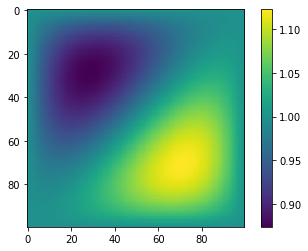

In [23]:
plt.imshow(approxs.reshape((100, 100)).detach().numpy())
plt.colorbar()

In [162]:
def make_section(y, fname, dpi=300):
    fig, ax = plt.subplots()

    xs = np.linspace(0, 1, 100)
    ys = np.full((len(xs), 1), y, np.float32)
    us = solver.model.forward(torch.Tensor(xs).float(),
                              torch.Tensor(ys).float()).detach().numpy()
    ax.plot(xs, us, linewidth=3, alpha=0.8, color='r')
    ax.add_patch(plt.Circle([0.0, 1.0], .007, color='b', alpha=0.3))
    ax.add_patch(plt.Circle([1.0, 1.0], .007, color='b', alpha=0.3))
    ax.plot(xs, np.full_like(xs, 1.0), 'b--', alpha=0.3,
            label=fr'$u(x, y={0:3.1f})$')

    plt.xlabel(r'x', fontsize=16)
    plt.ylabel('Section of solution-approximation', fontsize=16)
    plt.ylim((0.85, 1.15))
    plt.legend(loc=2)
    plt.grid()
    plt.title(fr'$u(x, y={y:3.1f})$', fontsize=18)
    plt.savefig(fname, dpi=dpi)
    plt.close()

In [190]:
# for i, y in enumerate([0, 0, 0, 0, 0] + np.linspace(0, 1, 100).tolist()
#                       + [1.0, 1.0, 1.0, 1.0, 1.0]):
#     make_section(y, fname=f'./pics_paper/y_{i:03d}')

## PDE laplace with fading bulb

In [213]:
def source(x, y):
    return (100 * x * (1 - x) * 4 * y * (.5 - y) * (1 - y) *
            torch.exp(-70 * (x - y)**2))

In [214]:
def pde(f, x, y):
    return D(D(f, x), x) + D(D(f, y), y) - source(x, y)

In [221]:
solver = Solver(pde, ndims=2, boundary_condition=1)

In [222]:
solver.fit(niters=1500, batch_size=400, lr=0.05)

100%|██████████| 1500/1500 [00:09<00:00, 152.55it/s]


In [223]:
approxs = solver.model(torch.tensor(grid[:, 0:1]).float(),
                       torch.tensor(grid[:, 1:2]).float())

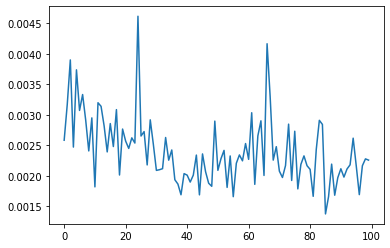

In [224]:
plt.plot(solver.losses[-100:])

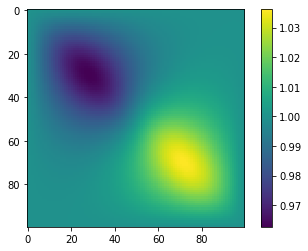

In [225]:
plt.imshow(approxs.reshape((100, 100)).detach().numpy())
plt.colorbar()

In [228]:
def make_section(y, fname, dpi=300):
    fig, ax = plt.subplots()

    xs = np.linspace(0, 1, 100)
    ys = np.full((len(xs), 1), y, np.float32)
    us = solver.model.forward(torch.Tensor(xs).float(),
                              torch.Tensor(ys).float()).detach().numpy()
    ax.plot(xs, us, linewidth=3, alpha=0.8, color='r')
    ax.add_patch(plt.Circle([0.0, 1.0], .004, color='b', alpha=0.3))
    ax.add_patch(plt.Circle([1.0, 1.0], .004, color='b', alpha=0.3))
    ax.plot(xs, np.full_like(xs, 1.0), 'b--', alpha=0.3,
            label=fr'$u(x, y={0:3.1f})$')

    plt.xlabel(r'x', fontsize=16)
    plt.ylabel('Section of solution-approximation', fontsize=16)
    plt.ylim((0.96, 1.04))
    plt.legend(loc=2)
    plt.grid()
    plt.title(fr'$u(x, y={y:3.1f})$', fontsize=18)
    plt.savefig(fname, dpi=dpi)
    plt.close()

In [229]:
for i, y in enumerate([0, 0, 0, 0, 0] + np.linspace(0, 1, 100).tolist()
                      + [1.0, 1.0, 1.0, 1.0, 1.0]):
    make_section(y, fname=f'./pics_paper/fading_{i:03d}')

## Parametric family of ODEs

In [17]:
def odeparam(f, x, e):
    return D(f, x) - e * np.pi * torch.cos(e * np.pi * x)

In [36]:
solver = Solver(odeparam, ndims=1, initial_condition=2, nparams=1)

In [37]:
sampler = NS('u') & NS('u', low=.5, high=5.5)

In [38]:
solver.fit(niters=10000, batch_size=700, sampler=sampler)

100%|██████████| 10000/10000 [00:21<00:00, 466.85it/s]


In [44]:
# checking out the solution approximation for fixed epsilon
eps = 5
approxs = solver.model(xs, torch.ones_like(xs) * eps)
true = np.sin(eps * np.pi * xs.numpy()) + 2

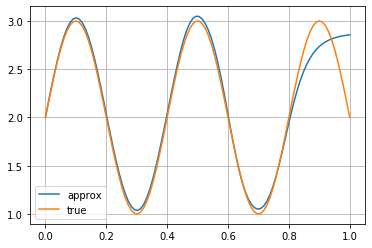

In [45]:
plt.plot(xs.detach().numpy(), approxs.detach().numpy(), label='approx')
plt.plot(xs.detach().numpy(), true, label='true')
plt.grid()
plt.legend()

In [28]:
# perhaps add capability to fix the parameter

## Heat equation in 2D (metal plate)

In [265]:
def pde(f, x, y, t, a):
    return D(D(f, x), x) + D(D(f, y), y) - a * D(f, t)

In [266]:
solver = Solver(pde, ndims=3, nparams=1,
                initial_condition=lambda x, y: 10 * x * y * (1 - x) * (1 - y),
                boundary_condition=0)

In [267]:
sampler = NS('u', dim=2) & NS('u', low=0, high=.5) &  NS('u', low=.1, high=4)

In [268]:
solver.fit(niters=5000, batch_size=1500, lr=0.01)

100%|██████████| 5000/5000 [01:51<00:00, 45.00it/s]


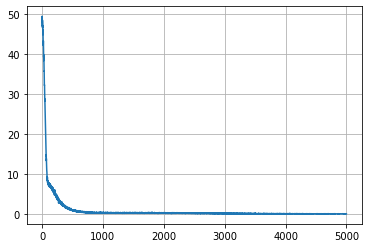

In [270]:
plt.plot(solver.losses[:])
plt.grid()

In [251]:
vmin, vmax = -0.01, 0.63

def plot(t=.1, param=1.):
    grid = cart_prod(np.linspace(0, 1, 100),
                     np.linspace(0, 1, 100))

    xs, ys = torch.tensor(grid[:, 0:1]).float(), torch.tensor(grid[:, 1:2]).float()
    ts = torch.full_like(xs, t)
    ps = torch.full_like(xs, param)

    approxs = solver.model(xs, ys, ts, ps)

    plt.imshow(approxs.reshape((100, 100)).detach().numpy(), vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

In [252]:
def get_approxs(t=.1, param=1.):
    grid = cart_prod(np.linspace(0, 1, 100),
                     np.linspace(0, 1, 100))

    xs, ys = torch.tensor(grid[:, 0:1]).float(), torch.tensor(grid[:, 1:2]).float()
    ts = torch.full_like(xs, t)
    ps = torch.full_like(xs, param)

    return solver.model(xs, ys, ts, ps).reshape((100, 100)).detach().numpy()

In [253]:
# for param in np.linspace(.1, 4, 30):
#     plot(param=param, t=.07)

In [254]:
a, t = .3, 5
fr'$t={t:4.2f}, \quad a={a:4.2f},' + '\quad \rm{diffusivity}=a=' + fr'{1/a:4.2f}$'

'$t=5.00, \\quad a=0.30,\\quad \rm{diffusivity}=a=3.33$'

In [246]:
def create_and_save(z, alpha=1.0, fname='', a=1., t=1., e=1e-2):
    if (np.max(z) - np.min(z)) < e:
        print('YEP, all close')
        z = np.full_like(z, 0.0)

    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1.8, y=1.3, z=.6)
    )
    layout = go.Layout(width=600,
                       scene_camera=camera,
                       title={
                        'text': fr'$t={t:4.2f}, \quad a={a:4.2f},' + '\quad diffusivity=1/a=' + fr'{1/a:4.2f}$',
                        'y':0.8,
                        'x':0.5,
                        'xanchor': 'center',
                        'font': {'size': 22}
#                         'yanchor': 'top'
                       },
                       height=600, scene=dict(xaxis=dict(nticks=12, range=[0, 100],
                                                         title='x',
                                                         showticklabels=False,
                                                         showbackground=True,
                                                         backgroundcolor="rgb(0, 0, 0)",
                                                         gridcolor="rgb(0, 153, 51)"),
                                              yaxis=dict(showticklabels=False,
                                                         title='y',
                                                         showbackground=True,
                                                         backgroundcolor="rgb(0, 0, 0)",
                                                         gridcolor="rgb(0, 153, 51)"),
                                              zaxis=dict(showticklabels=False,
                                                         title='u(x, y, t=t)',
                                                         nticks=6, range=[0, .8],
                                                         showbackground=True,
                                                         backgroundcolor="rgb(0, 0, 0)",
                                                         gridcolor="rgb(0, 153, 51)")))
    fig = go.Figure(data=[
        go.Surface(z=z,
                   showscale=True, opacity=0.95,
                   colorscale='Rainbow',
                   cmin=-0.05,
                   cmax=.65
                   ),
    ], layout=layout)
    fig.write_image(fname, scale=1.2, engine='kaleido')

In [178]:
a = 1.5
# ts = [0, 0, 0, 0]
ts = [0, 0, 0, 0] + np.linspace(0, .25, 30).tolist()

for i, t in enumerate(ts):
    ar = get_approxs(t, p)
    create_and_save(ar, fname=f'pics_paper/p_{p:.2f}_{i:02d}.png',
                    t=t, a=p)

In [137]:
from glob import glob

In [70]:
sorted(glob('./pics_paper/p_?.?0_??.png'))

['./pics_paper/p_0.20_00.png',
 './pics_paper/p_0.20_01.png',
 './pics_paper/p_0.20_02.png',
 './pics_paper/p_0.20_03.png',
 './pics_paper/p_0.20_04.png',
 './pics_paper/p_0.20_05.png',
 './pics_paper/p_0.20_06.png',
 './pics_paper/p_0.20_07.png',
 './pics_paper/p_0.20_08.png',
 './pics_paper/p_0.20_09.png',
 './pics_paper/p_0.20_10.png',
 './pics_paper/p_0.20_11.png',
 './pics_paper/p_0.20_12.png',
 './pics_paper/p_0.20_13.png',
 './pics_paper/p_0.20_14.png',
 './pics_paper/p_0.20_15.png',
 './pics_paper/p_0.20_16.png',
 './pics_paper/p_0.20_17.png',
 './pics_paper/p_0.20_18.png',
 './pics_paper/p_0.20_19.png',
 './pics_paper/p_0.20_20.png',
 './pics_paper/p_0.20_21.png',
 './pics_paper/p_0.20_22.png',
 './pics_paper/p_0.20_23.png',
 './pics_paper/p_0.20_24.png',
 './pics_paper/p_0.20_25.png',
 './pics_paper/p_0.20_26.png',
 './pics_paper/p_0.20_27.png',
 './pics_paper/p_0.20_28.png',
 './pics_paper/p_0.20_29.png',
 './pics_paper/p_0.20_30.png',
 './pics_paper/p_0.20_31.png',
 './pics

In [114]:
import os
def make_video_by_mask(mask=f'pics_paper/p_{p:.2f}_%02d.png', fps=6, name='video.mp4'):
    os.system(f"ffmpeg -r {fps} -i {mask} -vcodec mpeg4 -y {name}")

In [112]:
def clear_all_by_mask(mask=f'pics_paper/*.png'):
    os.system(f'rm -r {mask}')

In [53]:
mask = f'pics_paper/p_{p:.2f}_%02d.png'

* trying to make video with freeze in two steps with diff fps

In [176]:
clear_all_by_mask(mask='pics_paper/p_?.??_??.png')

* gather means

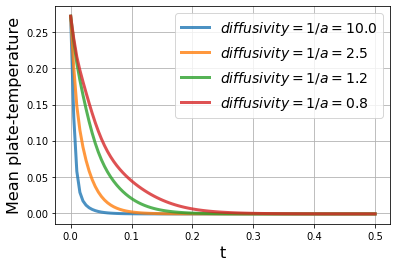

In [182]:
xs = np.linspace(0, .5, 100)
for p in [.1, .4, .8, 1.2]:
    plt.plot(xs, [np.mean(get_approxs(t=t, param=p)) for t in xs],
             label=fr'$diffusivity= 1 / a = {1 / p:3.1f}$', linewidth=3, alpha=0.8)
plt.legend(fontsize=14)
plt.xlabel(r't', fontsize=16)
plt.ylabel('Mean plate-temperature', fontsize=16)
plt.grid()
plt.savefig('./pics_paper/means_for_as_range.png', dpi=300)

## ODE with trainable coefficients

In [2]:
def odevar(f, x):
    return (D(f, x) - 2 * np.pi * torch.cos(2 * np.pi * x)
            + V('new_var', data=torch.Tensor([1.0]), requires_grad=True))

In [3]:
solver = Solver(odevar, ndims=1, initial_condition=1,
                constraints=lambda f, x: f(torch.tensor([0.5])))

NameError: name 'Solver' is not defined

* learning to solve the equation with fixed value of the variable

In [6]:
solver.model.freeze_layers(variables=('new_var',))

In [7]:
solver.fit(niters=2000, batch_size=400)

100%|██████████| 2000/2000 [00:04<00:00, 479.69it/s]


In [24]:
xs = torch.tensor(np.linspace(0, 1, 100)).float()
approxs = solver.model(xs)

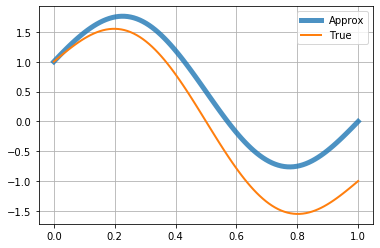

In [11]:
plt.plot(xs.detach().numpy(), approxs.detach().numpy(), label='Approx',
         linewidth=5, alpha=0.8)
plt.plot(xs.detach().numpy(), np.sin(2 * np.pi * xs.detach().numpy()) + 1 - 
         2* xs.detach().numpy(),
         label='True', linewidth=2)
plt.grid()
plt.legend()

* the additional constraint isn't satisfied - let's fix it

In [12]:
solver.model.unfreeze_layers(variables=['new_var'])

In [17]:
solver.fit(niters=1500, batch_size=400, losses=['equation', 'constraint_0'])

100%|██████████| 500/500 [00:01<00:00, 354.44it/s]


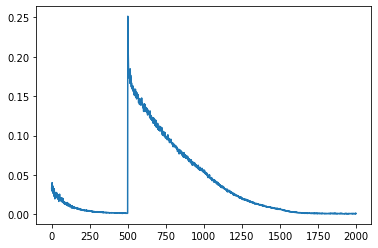

In [22]:
plt.plot(solver.losses[1500:])

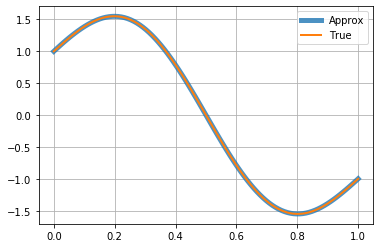

In [25]:
plt.plot(xs.detach().numpy(), approxs.detach().numpy(), label='Approx',
         linewidth=5, alpha=0.8)
plt.plot(xs.detach().numpy(), np.sin(2 * np.pi * xs.detach().numpy()) + 1 - 
         2* xs.detach().numpy(),
         label='True', linewidth=2)
plt.grid()
plt.legend()

* cool, everything is now satisfied

## ODE with trainable coefficients (2) for main page

In [299]:
def odevar(u, t):
    return D(u, t) - 2 * np.pi * torch.cos(2 * np.pi * t)
def initial(*args):
    return V('init', data=torch.Tensor([4.0]))

In [300]:
solver = Solver(odevar, ndims=1, initial_condition=initial,
                constraints=lambda u, t: u(torch.tensor([0.5])) - 2)

In [301]:
solver.model.freeze_layers(variables=('init',))

In [302]:
solver.fit(niters=150, batch_size=500, lr=0.05)



  0%|          | 0/150 [00:00<?, ?it/s]

 19%|█▊        | 28/150 [00:00<00:00, 270.92it/s]

 37%|███▋      | 55/150 [00:00<00:00, 268.31it/s]

 53%|█████▎    | 79/150 [00:00<00:00, 258.86it/s]

 67%|██████▋   | 101/150 [00:00<00:00, 243.53it/s]

100%|██████████| 150/150 [00:00<00:00, 250.14it/s]


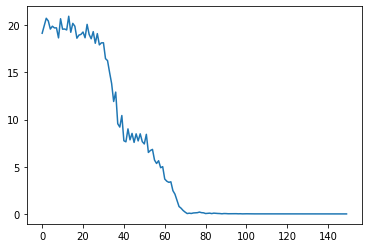

In [303]:
plt.plot(solver.losses[:])

In [304]:
xs = torch.Tensor(np.linspace(0, 1, 100))
approxs = solver.ctx.run(solver.model, xs)

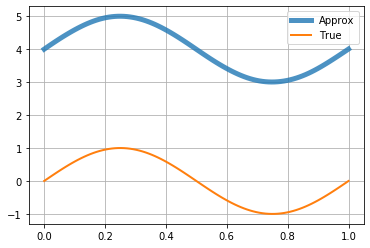

In [305]:
plt.plot(xs.detach().numpy(), approxs.detach().numpy(), label='Approx',
         linewidth=5, alpha=0.8)
plt.plot(xs.detach().numpy(), np.sin(2 * np.pi * xs.detach().numpy()),
         label='True', linewidth=2)
plt.grid()
plt.legend()

In [306]:
# solver.model.freeze_layers(['fc1', 'fc2', 'fc3'], ['log_scale'])
solver.model.unfreeze_layers(variables=['init'])

In [307]:
solver.fit(niters=100, batch_size=100, lr=0.1,
           losses=['equation', 'constraint_0'])



  0%|          | 0/100 [00:00<?, ?it/s]/Users/aleksandr/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning:

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



 21%|██        | 21/100 [00:00<00:00, 205.68it/s]

 43%|████▎     | 43/100 [00:00<00:00, 209.04it/s]

 65%|██████▌   | 65/100 [00:00<00:00, 209.63it/s]

100%|██████████| 100/100 [00:00<00:00, 209.42it/s][A


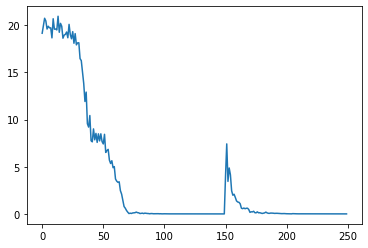

In [308]:
plt.plot(solver.losses[:])

In [309]:
approxs = solver.ctx.run(solver.model, xs)

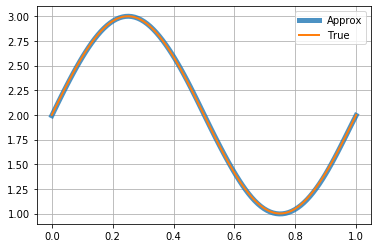

In [311]:
plt.plot(xs.detach().numpy(), approxs.detach().numpy(), label='Approx',
         linewidth=5, alpha=0.8)
plt.plot(xs.detach().numpy(), np.sin(2 * np.pi * xs.detach().numpy()) + 2,
         label='True', linewidth=2)
plt.grid()
plt.legend()